In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.signal import savgol_filter

import seaborn as sns
sns.set_theme(font_scale=1.5);

In [202]:
h        = np.linspace(0, 999, 1000);
Earray   = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)
binWidth = np.hstack([np.diff(Earray), np.diff(Earray)[-1]]);

from matplotlib.colors import LogNorm

def KrauseIonization(altitude):
    '''
    altitude in km
    returns ionization in keV
    '''
    r = (-0.03 * altitude + 39.78)/1e3;
    r[altitude > 240] = (-0.03 * 240 + 39.78)/1e3
    r[altitude < 45] = (-0.03 * 45 + 39.78)/1e3

    return r;

def readAndAverage(filename):
    data = pd.read_csv("../build/" + filename, names=['E']);

    lineNo   = 1000;

    nThreads = int(len(data)/lineNo);
    
    ionResults = np.zeros([1, lineNo]);
    ionVar     = np.zeros([1, lineNo]);
    for i in range(0, nThreads):
        ionResults += data.E[lineNo*i:lineNo*(i+1)]
    
    for i in range(0, nThreads):
        ionVar += (data.E[lineNo*i:lineNo*(i+1)] - ionResults[0,:])**2;
    
    return ionResults.flatten(), np.sqrt(1/(nThreads-1) * ionVar.flatten());

def readAndAverage2D(filename):
    
    Earray = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)

    data = pd.read_csv("../build/" + filename, names=Earray);
    
    lineNo   = 1000;
    
    nThreads = int(len(data)/lineNo);
    
    data.fillna(data.mean(), inplace=True)

    results    = np.zeros([lineNo, 100]);
    resultsVar = np.zeros([lineNo, 100]);
    for i in range(0, nThreads):
        results += data.values[lineNo*i:lineNo*(i+1), :];
        
    for i in range(0, nThreads):
        resultsVar += (data.values[lineNo*i:lineNo*(i+1), :]/binWidth - results/binWidth)**2;

    return results/binWidth, np.sqrt(1/(nThreads - 1) * resultsVar);
    
def plot_spectra(ionResults, EResults, ionVar, Evar):

    plt.figure(figsize=(14,8)); plt.subplot(1,2,1); 
    plt.grid(True, which='both')
    #plt.plot(ionResults/KrauseIonization(h), h, label='$\mu$');
    #plt.fill_betweenx(h, (ionResults-ionVar)/KrauseIonization(h), 
    #                     (ionResults+ionVar)/KrauseIonization(h), 
    #                  alpha=0.5, label='$\pm \sigma$')
    
    plt.plot(ionResults, h, label='$\mu$');
    plt.fill_betweenx(h, (ionResults-ionVar), 
                         (ionResults+ionVar), 
                      alpha=0.5, label='$\pm \sigma$')
    
    plt.xscale('log');
    plt.xlabel('Deposited Energy [keV/km]');
    plt.ylabel('Altitude [km]');
    #plt.ylim([0, 240]);
    plt.legend()

    X,Y = np.meshgrid(Earray, h);

    #ionVar[h < 120] *= 2;
    
    plt.subplot(1,2,2); plt.grid(True, which='both')
    #plt.contourf(X, Y, EResults, norm=LogNorm());
    plt.pcolormesh(X, Y, EResults, norm=LogNorm());

    plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');

    plt.xscale('log');
    plt.xlabel('Energy [keV]');
    plt.ylabel('Altitude [km]');
    #plt.ylim([0, 240]);

def plot_altitude_spectra(EResults, Evar):
    plt.figure(figsize=(10,6)); plt.grid(True, which='both');

    startingAlt = 10;
    stepSize    = 5;

    for j in range(0, 4):

        h1 = startingAlt + j*stepSize;
        h2 = startingAlt + stepSize + j*stepSize;

        ave    = np.zeros([1, len(Earray)])
        aveVar = np.zeros([1, len(Earray)])
        for i in range(h1, h2):
            ave += EResults[i, :]
            aveVar += np.sqrt(Evar[i,:])

        plt.errorbar(Earray, savgol_filter(ave[0,:], 1, 0), aveVar[0,:], label='%.0f - %.0f km' % (h1,h2));
        
    startingAlt = 500;
    stepSize    = 5;

    for j in range(0, 1):

        h1 = startingAlt + j*stepSize;
        h2 = startingAlt + stepSize + j*stepSize;

        ave    = np.zeros([1, len(Earray)])
        aveVar = np.zeros([1, len(Earray)])
        for i in range(h1, h2):
            ave    += EResults[i, :]
            aveVar += np.sqrt(Evar[i,:])

        plt.errorbar(Earray, savgol_filter(ave[0,:], 1, 0), aveVar[0,:], label='%.0f - %.0f km' % (h1,h2));
        
        
    plt.xscale('log');
    plt.yscale('log');
    plt.legend();
    plt.xlabel('Energy [keV]');
    plt.ylabel('Relative Intensity');
    plt.title('Average Spectra with Altitude');
    
    
def plot_altitude_energy_spectra(EResults, Evar):
    plt.figure(figsize=(8,10)); plt.grid(True, which='both');

    windowSize = 10;
    
    for j in [1e1, 1e2, 1e3, 1e4]:
        
        E1 = j;
        E2 = j*windowSize
        
        inds = (Earray > E1) & (Earray < E2);

        #ave    = np.mean(EResults[:,inds], axis=1);
        ave    = np.trapz(EResults[:,inds], x=Earray[inds])
        #aveVar = np.mean(np.sqrt(Evar[:,inds]), axis=1);
        
        plt.step(savgol_filter(ave, 1, 0), h, label='%.2f - %.1f MeV' % (E1/1e3,E2/1e3));

    plt.xscale('log');
    plt.legend();
    plt.xlabel('Photon Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$]');
    plt.ylabel('Altitude [km]');
    plt.title('Average Spectra with Altitude');
    #plt.xlim([0, 500]);

Electrons from spectra: 1.454e+07 
Electrons from ionization: 9.481e+06
Photons from spectra: 3.861e+05 
Photons from ionization: 2.615e+04
Both from spectra: (1.4924e+07 keV) 149.24%
Both from ionization: (9.5074e+06 keV) 95.07%


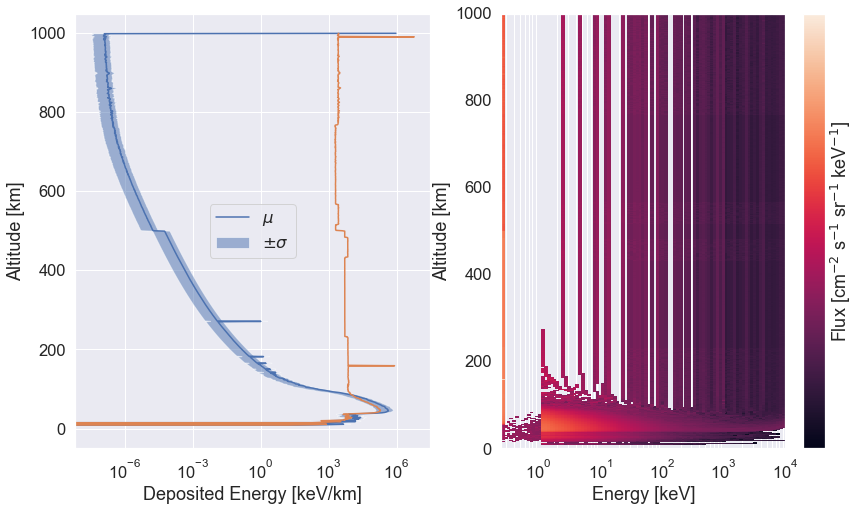

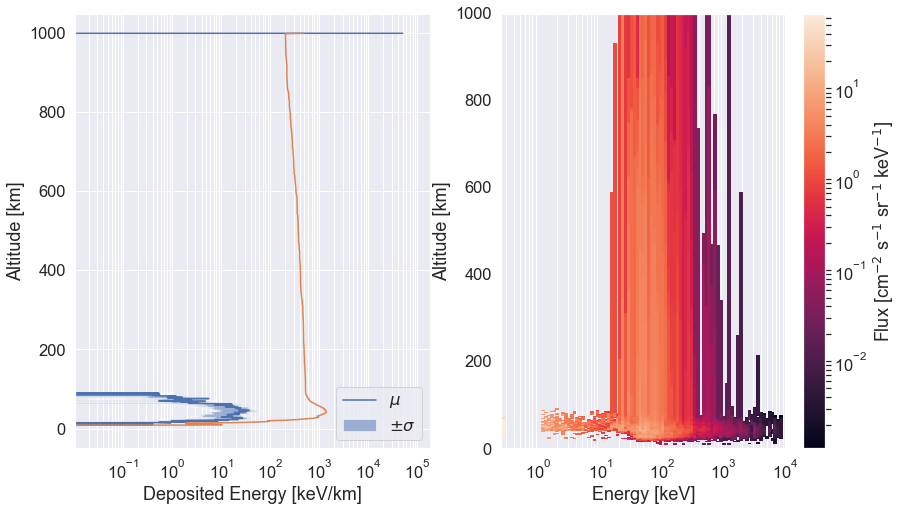

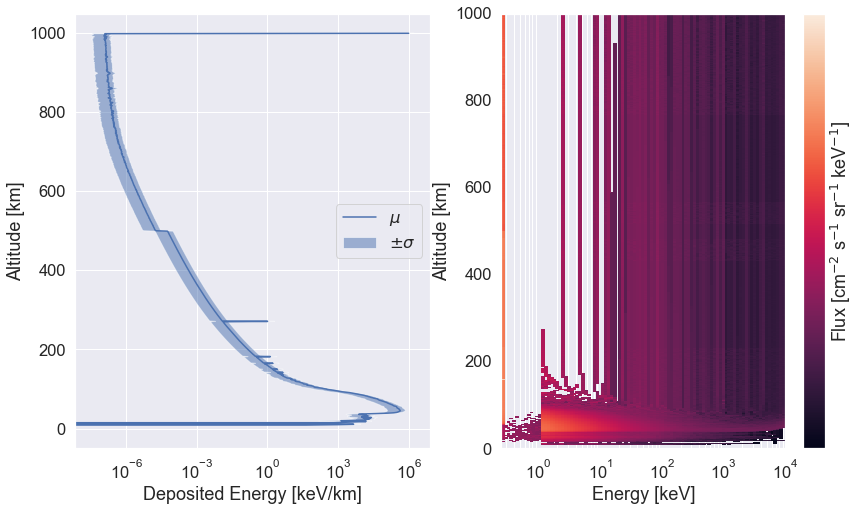

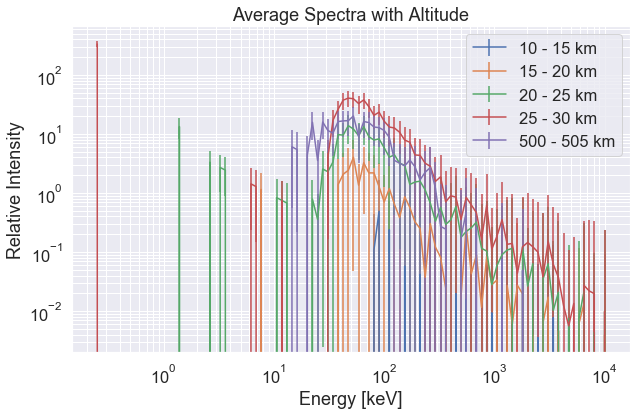

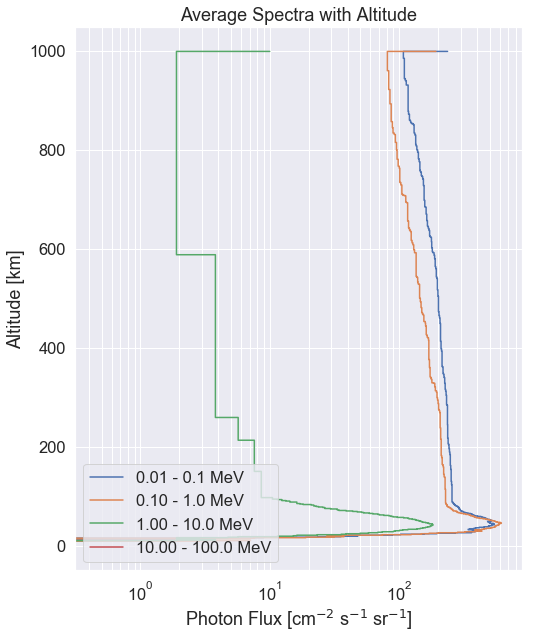

In [203]:
fn1 = "electron_dep_test.csv"
fn2 = "electron_ene_test.csv"
fn3 = "photon_dep_test.csv"
fn4 = "photon_ene_test.csv"

ionResults, ionVar       = readAndAverage(fn1);
EResults, Evar           = readAndAverage2D(fn2);
ph_ionResults, ph_ionVar = readAndAverage(fn3);
ph_EResults, ph_Evar     = readAndAverage2D(fn4);


plot_spectra(ionResults, EResults, ionVar, Evar);

plt.subplot(1,2,1);
plt.plot(np.trapz(EResults, x=Earray, axis=1), h)

#plt.ylim(0, 100);
#plt.xlim(1e1, 1e5)


print("Electrons from spectra: %.3e " % np.trapz(np.trapz(EResults, x=Earray, axis=1), x=h, axis=0))
print("Electrons from ionization: %.3e" % np.trapz(ionResults, x=h, axis=0))

print("Photons from spectra: %.3e " % (np.trapz(np.trapz(ph_EResults, x=Earray, axis=1), x=h, axis=0)))
print("Photons from ionization: %.3e" % (np.trapz(ph_ionResults, x=h, axis=0)))


print("Both from spectra: (%.4e keV) %.2f%%" % ((np.trapz(np.trapz(EResults, x=Earray, axis=1), x=h, axis=0) + 
                                          np.trapz(np.trapz(ph_EResults, x=Earray, axis=1), x=h, axis=0)), 
                                      (np.trapz(np.trapz(EResults, x=Earray, axis=1), x=h, axis=0) + 
                                          np.trapz(np.trapz(ph_EResults, x=Earray, axis=1), x=h, axis=0))/1e7 * 100))

print("Both from ionization: (%.4e keV) %.2f%%" % ((np.trapz(ionResults, x=h, axis=0) + 
                                      np.trapz(ph_ionResults, x=h, axis=0)), (np.trapz(ionResults, x=h, axis=0) + 
                                      np.trapz(ph_ionResults, x=h, axis=0))/1e7 * 100))

plot_spectra(ph_ionResults, ph_EResults, ph_ionVar, ph_Evar)

plt.subplot(1,2,1);
plt.plot(np.trapz(ph_EResults, x=Earray), h)

plot_spectra(savgol_filter(ionResults + ph_ionResults, 1, 0), 
             (EResults+ph_EResults), 
             savgol_filter(ionVar+ph_ionVar, 1,0), 
             Evar+ph_Evar);

plt.subplot(1,2,1);
#plt.ylim(0, 200);
#plt.xlim(1e-2, 1e5);
     
plt.subplot(1,2,2);
#plt.ylim(0, 200);
#plt.xlim(8e-1, 3e4);

    
plot_altitude_spectra(ph_EResults, ph_Evar);
plot_altitude_energy_spectra(ph_EResults, ph_Evar);
#plt.ylim(0, 80);

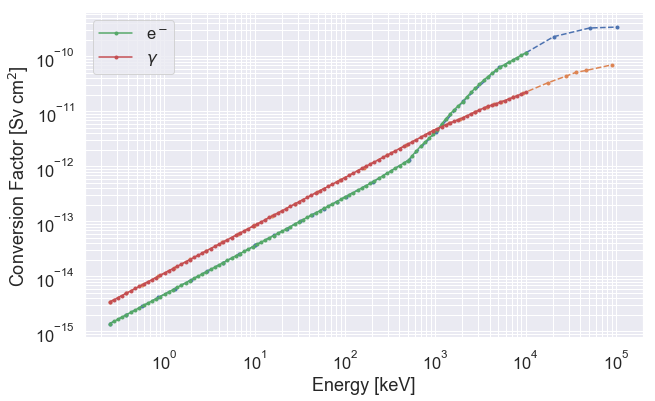

In [75]:
def extrapolateLowEnd(data, Elow):
    
    fit  = np.polyfit(np.log10(data[0:8,0]), np.log10(data[0:8,1]) , 1);

    line = np.poly1d(fit);
    
    # Reassemble data array 
    A = np.concatenate([Elow, data[:,0]]);
    B = np.concatenate([10**line(np.log10(Elow)), data[:,1]]);
        
    return np.vstack([A, B]).T;
    

# (electron energy [eV], conversion factor [Sv cm^2])
el_conv = np.array([[1.0217e+4, 3.6869e-14],
                    [1.6588e+4, 5.6234e-14],
                    [2.2729e+4, 7.3564e-14],
                    [3.1526e+4, 1.0000e-13],
                    [4.3197e+4, 1.3082e-13],
                    [5.8478e+4, 1.7113e-13],
                    [8.1106e+4, 2.2821e-13],
                    [1.0210e+5, 2.8184e-13],
                    [2.0368e+5, 5.2079e-13],
                    [5.1162e+5, 1.3082e-12],
                    [1.0221e+6, 4.2170e-12],
                    [2.0425e+6, 1.5252e-11],
                    [5.1374e+6, 6.3096e-11],
                    [1.0125e+7, 1.1659e-10],
                    [2.0447e+7, 2.2821e-10],
                    [5.1286e+7, 3.2860e-10],
                    [1.0340e+8, 3.4145e-10]]);

ph_conv = np.array([[9.9309e+3, 8.3937e-14],
                    [1.5706e+4, 1.2555e-13],
                    [2.7780e+4, 2.0628e-13],
                    [4.9686e+4, 3.4351e-13],
                    [8.8869e+4, 5.6439e-13],
                    [1.6073e+5, 9.5257e-13],
                    [2.9072e+5, 1.5862e-12],
                    [4.7548e+5, 2.4371e-12],
                    [9.4043e+5, 4.4583e-12],
                    [1.4225e+6, 6.0694e-12],
                    [1.9027e+6, 7.3223e-12],
                    [2.7830e+6, 9.8361e-12],
                    [3.7223e+6, 1.2190e-11],
                    [4.4521e+6, 1.3388e-11],
                    [5.3849e+6, 1.4903e-11],
                    [7.2839e+6, 1.7979e-11],
                    [9.4211e+6, 2.1402e-11],
                    [1.7824e+7, 3.3314e-11],
                    [2.7885e+7, 4.3553e-11],
                    [3.6068e+7, 5.1152e-11],
                    [4.6662e+7, 5.5415e-11],
                    [9.1344e+7, 7.0475e-11]])


el_conv = extrapolateLowEnd(el_conv, np.logspace(np.log10(Earray[0]*1e3), np.log10(el_conv[0,0]), 10));
ph_conv = extrapolateLowEnd(ph_conv, np.logspace(np.log10(Earray[0]*1e3), np.log10(ph_conv[0,0]), 10));


el_resamp = np.interp(Earray, el_conv[:,0]/1000, el_conv[:,1]);
ph_resamp = np.interp(Earray, ph_conv[:,0]/1000, ph_conv[:,1]);


plt.figure(figsize=(10,6)); plt.grid(True, which='both');
plt.plot(el_conv[:,0]*1e-3, el_conv[:,1], '.--');
plt.plot(ph_conv[:,0]*1e-3, ph_conv[:,1], '.--')
plt.plot(Earray, el_resamp, '.-', label='e$^-$');
plt.plot(Earray, ph_resamp, '.-', label='$\gamma$');
plt.legend();
plt.xscale('log');
plt.yscale('log');
plt.xlabel('Energy [keV]');
plt.ylabel('Conversion Factor [Sv cm$^2$]');

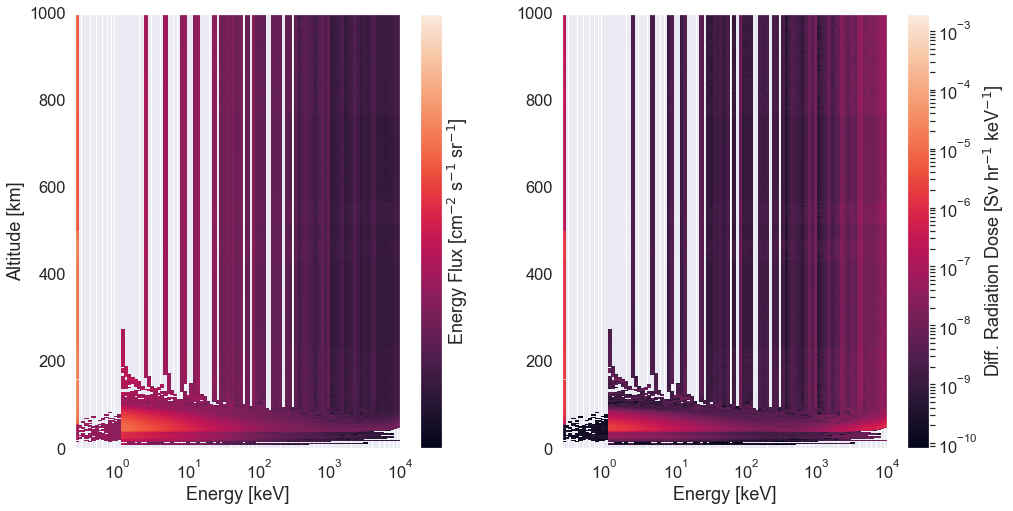

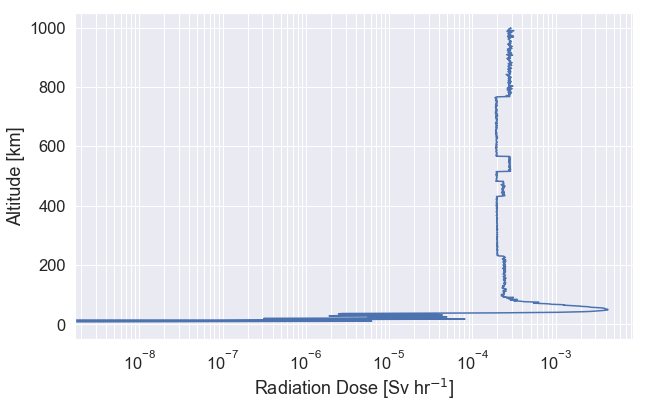

In [185]:
'''
def convertToRadDose(el_spectra, ph_spectra):
    
    dosage_alt_array = np.zeros([1000]);
    
    for i in range(0, len(el_spectra)):
        dosage_alt_array[i] = np.sum(el_spectra[i,:] * el_resamp) + np.sum(ph_spectra[i,:] * ph_resamp);
        
    i = 90;
    print(el_spectra[i,:])
    print(el_resamp)
        
    print(el_spectra[i,:] * el_resamp)
        
    return dosage_alt_array;
''';      
    
def convertToRadDose(el_spectra, ph_spectra):
    
    dosage_alt_array = np.zeros([1000, 100]);
    
    for i in range(0, 1000):
        dosage_alt_array[i,:] = el_spectra[i,:] * el_resamp;# + np.sum(ph_spectra[i,:] * ph_resamp);

    return dosage_alt_array;
    
#d = convertToRadDose(EResults, ph_EResults/1e3);

'''
plt.figure(figsize=(10,8)); plt.grid(True, which='both')
plt.plot(savgol_filter(d, 11, 1)*3600, h);
plt.xlabel('Radiation Dose [Sv hr$^{-1}$]');
plt.ylabel('Altitude [km]');
plt.xscale('log');
#plt.xlim([5e-3*3600*1e-6, 5e-1*3600*1e-6]);
#plt.ylim([1e0, 1e3]);
#plt.yscale('log');
''';

X, Y = np.meshgrid(Earray, h);
import matplotlib.colors as cl

plt.figure(figsize=(16,8)); 

plt.subplot(1,2,1); plt.grid(True, which='both');

plt.pcolormesh(X, Y, EResults, norm=LogNorm())
plt.colorbar(label='Energy Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$]');

plt.xscale('log');
#plt.xlim(1e-1, 3e4);
plt.xlabel('Energy [keV]')
plt.ylabel('Altitude [km]');

#plt.ylim(0, 200);


plt.subplot(1,2,2); plt.grid(True, which='both');

A = convertToRadDose(EResults, ph_EResults/1e3)*3600

plt.pcolormesh(X, Y, A, norm=LogNorm());
#plt.plot(np.sum(convertToRadDose(EResults, ph_EResults/1e3)*3600, axis=1), h, 'b');

#plt.ylim(0, 200);

plt.colorbar(label='Diff. Radiation Dose [Sv hr$^{-1}$ keV$^{-1}$]');

plt.xlabel('Energy [keV]');
#plt.ylabel('Altitude [km]');
plt.xscale('log');
#plt.yscale('log');

#plt.xlim([1e-1, 3e4]);


plt.figure(figsize=(10,6)); plt.grid(True, which='both')
plt.plot(np.trapz(A, x=Earray), h, 'b');
plt.xscale('log');
plt.ylabel('Altitude [km]');
plt.xlabel('Radiation Dose [Sv hr$^{-1}$]');
#plt.ylim(0, 200);
#plt.xlim(1e-5, 1e-3);